In [1]:
from copy import copy
import math
import os
from pathlib import Path
import pickle
from adjustText import adjust_text
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from citylearn.cost_function import CostFunction
from database import SQLiteDatabase
from experiment import preliminary_setup, set_brief_summary, set_detailed_summary

# Scores to calculate
1. Net electricity consumption
2. Carbon emissions
3. Electricity bill
4. Ramping
5. 1 - load factor
6. Daily peak

In [48]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DB_DIRECTORY = KWARGS['database_directory']
MISC_DIRECTORY = KWARGS['misc_directory']
SUMMARY_DIRECTORY = KWARGS['summary_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
db = SQLiteDatabase(os.path.join(DB_DIRECTORY,'reward_design.db'))
GRID = db.get_table('grid')
SIMULATION_GROUPS = GRID['simulation_group'].unique()

## Building level scores

In [47]:
query = f"""
WITH d AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        t.timestamp,
        t.net_electricity_consumption,
        t.net_electricity_consumption_without_storage,
        t.net_electricity_consumption_emission,
        t.net_electricity_consumption_emission_without_storage,
        t.net_electricity_consumption_price,
        t.net_electricity_consumption_price_without_storage
    FROM detailed_summary t
    WHERE t.simulation_id IN {tuple(SIMULATION_IDS)}
), net_electricity_consumption AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_id,
        SUM(MAX(0, d.net_electricity_consumption))/SUM(MAX(0, d.net_electricity_consumption_without_storage)) AS value
    FROM d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_id
), carbon_emission AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_id,
        SUM(MAX(0, d.net_electricity_consumption_emission))/SUM(MAX(0, d.net_electricity_consumption_emission_without_storage)) AS value
    FROM d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_id
), price AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_id,
        SUM(MAX(0, d.net_electricity_consumption_price))/SUM(MAX(0, d.net_electricity_consumption_price_without_storage)) AS value
    FROM d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_id
), ramping AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        SUM(t.with_storage_value)/SUM(without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            ABS(d.net_electricity_consumption - LAG(d.net_electricity_consumption, 1) OVER (
                PARTITION BY d.simulation_id, d.episode, d.building_id ORDER BY d.timestamp ASC
            )) AS with_storage_value,
            ABS(d.net_electricity_consumption_without_storage - LAG(d.net_electricity_consumption_without_storage, 1) OVER (
                PARTITION BY d.simulation_id, d.episode, d.building_id ORDER BY d.timestamp ASC
            )) AS without_storage_value
        FROM d
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
), daily_peak AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        AVG(with_storage_value)/AVG(without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            MAX(d.net_electricity_consumption) AS with_storage_value,
            MAX(d.net_electricity_consumption_without_storage) AS without_storage_value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode,
            d.building_id,
            DATE(d.timestamp)
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
), daily_load_factor AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        AVG(with_storage_value)/AVG(without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            1 - (AVG(d.net_electricity_consumption)/MAX(d.net_electricity_consumption)) AS with_storage_value,
            1 - (AVG(d.net_electricity_consumption_without_storage)/MAX(d.net_electricity_consumption_without_storage)) AS without_storage_value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode,
            d.building_id,
            DATE(d.timestamp)
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
), monthly_load_factor AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        AVG(with_storage_value)/AVG(without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            1 - (AVG(d.net_electricity_consumption)/MAX(d.net_electricity_consumption)) AS with_storage_value,
            1 - (AVG(d.net_electricity_consumption_without_storage)/MAX(d.net_electricity_consumption_without_storage)) AS without_storage_value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode,
            d.building_id,
            STRFTIME('%Y', d.timestamp),
            STRFTIME('%m', d.timestamp)
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
), daily_net_zero AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        AVG(t.with_storage_value)/AVG(t.without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            SUM(d.net_electricity_consumption) AS with_storage_value,
            SUM(d.net_electricity_consumption_without_storage) AS without_storage_value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode,
            d.building_id,
            DATE(d.timestamp)
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
), annual_net_zero AS (
    SELECT
        t.simulation_id,
        t.episode,
        t.building_id,
        AVG(t.with_storage_value)/AVG(t.without_storage_value) AS value
    FROM (
        SELECT
            d.simulation_id,
            d.episode,
            d.building_id,
            SUM(d.net_electricity_consumption) AS with_storage_value,
            SUM(d.net_electricity_consumption_without_storage) AS without_storage_value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode,
            d.building_id,
            STRFTIME('%Y', d.timestamp)
    ) t
    GROUP BY
        t.simulation_id,
        t.episode,
        t.building_id
)

SELECT
    g.simulation_group,
    n.episode,
    n.building_id,
    AVG(n.value) AS net_electricity_consumption,
    AVG(c.value) AS carbon_emission,
    AVG(p.value) AS price,
    AVG(r.value) AS ramping,
    AVG(e.value) AS daily_peak,
    AVG(l.value) AS daily_load_factor,
    AVG(m.value) AS monthly_load_factor,
    AVG(d.value) AS daily_net_zero,
    AVG(a.value) AS annual_net_zero,
    (AVG(n.value) + AVG(c.value) + AVG(p.value) + AVG(r.value) + AVG(e.value) + AVG(l.value) + AVG(d.value))/7.0 AS average_score
FROM grid g
INNER JOIN net_electricity_consumption n ON n.simulation_id = g.simulation_id
LEFT JOIN carbon_emission c ON c.episode = n.episode AND c.building_id = n.building_id AND c.simulation_id = n.simulation_id
LEFT JOIN price p ON p.episode = n.episode AND p.building_id = n.building_id AND p.simulation_id = n.simulation_id
LEFT JOIN ramping r ON r.episode = n.episode AND r.building_id = n.building_id AND r.simulation_id = n.simulation_id
LEFT JOIN daily_peak e ON e.episode = n.episode AND e.building_id = n.building_id AND e.simulation_id = n.simulation_id
LEFT JOIN daily_load_factor l ON l.episode = n.episode AND l.building_id = n.building_id AND l.simulation_id = n.simulation_id
LEFT JOIN monthly_load_factor m ON m.episode = n.episode AND m.building_id = n.building_id AND m.simulation_id = n.simulation_id
LEFT JOIN daily_net_zero d ON d.episode = n.episode AND d.building_id = n.building_id AND d.simulation_id = n.simulation_id
LEFT JOIN annual_net_zero a ON a.episode = n.episode AND a.building_id = n.building_id AND a.simulation_id = n.simulation_id
GROUP BY
    g.simulation_group,
    n.episode,
    n.building_id
"""
building_data = db.query_table(query)

## District level scores

In [162]:
data_list = []

for i, (_, g_data) in enumerate(GRID.groupby(['simulation_group'])):
    query = f"""
    WITH d AS (
        SELECT
            t.simulation_id,
            t.episode,
            t.timestamp,
            SUM(t.net_electricity_consumption) AS net_electricity_consumption,
            SUM(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage,
            SUM(t.net_electricity_consumption_emission) AS net_electricity_consumption_emission,
            SUM(t.net_electricity_consumption_emission_without_storage) AS net_electricity_consumption_emission_without_storage,
            SUM(t.net_electricity_consumption_price) AS net_electricity_consumption_price,
            SUM(t.net_electricity_consumption_price_without_storage) AS net_electricity_consumption_price_without_storage
        FROM detailed_summary t
        WHERE t.simulation_id IN {tuple(g_data['simulation_id'].tolist())}
        GROUP BY
            t.simulation_id,
            t.episode,
            t.timestamp
    ), net_electricity_consumption AS (
        SELECT
            d.simulation_id,
            d.episode,
            SUM(MAX(0, d.net_electricity_consumption))/SUM(MAX(0, d.net_electricity_consumption_without_storage)) AS value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode
    ), carbon_emission AS (
        SELECT
            d.simulation_id,
            d.episode,
            SUM(MAX(0, d.net_electricity_consumption_emission))/SUM(MAX(0, d.net_electricity_consumption_emission_without_storage)) AS value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode
    ), price AS (
        SELECT
            d.simulation_id,
            d.episode,
            SUM(MAX(0, d.net_electricity_consumption_price))/SUM(MAX(0, d.net_electricity_consumption_price_without_storage)) AS value
        FROM d
        GROUP BY
            d.simulation_id,
            d.episode
    ), ramping AS (
        SELECT
            t.simulation_id,
            t.episode,
            SUM(t.with_storage_value)/SUM(without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                ABS(d.net_electricity_consumption - LAG(d.net_electricity_consumption, 1) OVER (
                    PARTITION BY d.simulation_id, d.episode ORDER BY d.timestamp ASC
                )) AS with_storage_value,
                ABS(d.net_electricity_consumption_without_storage - LAG(d.net_electricity_consumption_without_storage, 1) OVER (
                    PARTITION BY d.simulation_id, d.episode ORDER BY d.timestamp ASC
                )) AS without_storage_value
            FROM d
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    ), daily_peak AS (
        SELECT
            t.simulation_id,
            t.episode,
            AVG(with_storage_value)/AVG(without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                MAX(d.net_electricity_consumption) AS with_storage_value,
                MAX(d.net_electricity_consumption_without_storage) AS without_storage_value
            FROM d
            GROUP BY
                d.simulation_id,
                d.episode,
                DATE(d.timestamp)
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    ), daily_load_factor AS (
        SELECT
            t.simulation_id,
            t.episode,
            AVG(with_storage_value)/AVG(without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                1 - (AVG(d.net_electricity_consumption)/MAX(d.net_electricity_consumption)) AS with_storage_value,
                1 - (AVG(d.net_electricity_consumption_without_storage)/MAX(d.net_electricity_consumption_without_storage)) AS without_storage_value
            FROM d
            GROUP BY
                d.simulation_id,
                d.episode,
                DATE(d.timestamp)
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    ), monthly_load_factor AS (
        SELECT
            t.simulation_id,
            t.episode,
            AVG(with_storage_value)/AVG(without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                1 - (AVG(d.net_electricity_consumption)/MAX(d.net_electricity_consumption)) AS with_storage_value,
                1 - (AVG(d.net_electricity_consumption_without_storage)/MAX(d.net_electricity_consumption_without_storage)) AS without_storage_value
            FROM d
            GROUP BY
                d.simulation_id,
                d.episode,
                STRFTIME('%Y', d.timestamp),
                STRFTIME('%m', d.timestamp)
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    ), daily_net_zero AS (
        SELECT
            t.simulation_id,
            t.episode,
            AVG(t.with_storage_value)/AVG(t.without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                SUM(d.net_electricity_consumption) AS with_storage_value,
                SUM(d.net_electricity_consumption_without_storage) AS without_storage_value
            FROM d
            GROUP BY
                d.simulation_id,
                d.episode,
                DATE(d.timestamp)
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    ), annual_net_zero AS (
        SELECT
            t.simulation_id,
            t.episode,
            AVG(t.with_storage_value)/AVG(t.without_storage_value) AS value
        FROM (
            SELECT
                d.simulation_id,
                d.episode,
                SUM(d.net_electricity_consumption) AS with_storage_value,
                SUM(d.net_electricity_consumption_without_storage) AS without_storage_value
            FROM d
            GROUP BY
                d.simulation_id,
                d.episode,
                STRFTIME('%Y', d.timestamp)
        ) t
        GROUP BY
            t.simulation_id,
            t.episode
    )

    SELECT
        g.simulation_group,
        n.episode,
        AVG(n.value) AS net_electricity_consumption,
        AVG(c.value) AS carbon_emission,
        AVG(p.value) AS price,
        AVG(r.value) AS ramping,
        AVG(e.value) AS daily_peak,
        AVG(l.value) AS daily_load_factor,
        AVG(m.value) AS monthly_load_factor,
        AVG(d.value) AS daily_net_zero,
        AVG(a.value) AS annual_net_zero,
        (AVG(r.value) + AVG(e.value) + AVG(l.value))/3.0 AS coordination_score,
        (AVG(n.value) + AVG(c.value) + AVG(p.value) + AVG(r.value) + AVG(e.value) + AVG(l.value) + AVG(d.value))/7.0 AS average_score
    FROM grid g
    INNER JOIN net_electricity_consumption n ON n.simulation_id = g.simulation_id
    LEFT JOIN carbon_emission c ON c.episode = n.episode AND c.simulation_id = n.simulation_id
    LEFT JOIN price p ON p.episode = n.episode AND p.simulation_id = n.simulation_id
    LEFT JOIN ramping r ON r.episode = n.episode AND r.simulation_id = n.simulation_id
    LEFT JOIN daily_peak e ON e.episode = n.episode AND e.simulation_id = n.simulation_id
    LEFT JOIN daily_load_factor l ON l.episode = n.episode AND l.simulation_id = n.simulation_id
    LEFT JOIN monthly_load_factor m ON m.episode = n.episode AND m.simulation_id = n.simulation_id
    LEFT JOIN daily_net_zero d ON d.episode = n.episode AND d.simulation_id = n.simulation_id
    LEFT JOIN annual_net_zero a ON a.episode = n.episode AND a.simulation_id = n.simulation_id
    GROUP BY
        n.episode,
        g.simulation_group
    """
    data_list.append(db.query_table(query))
    print(f'\rRead {i+1}/{len(SIMULATION_GROUPS)}',end=''*10)

district_data = pd.concat(data_list,ignore_index=True,sort=False)
del data_list
district_data.to_csv(os.path.join(SUMMARY_DIRECTORY,'reward_design_district_episode_score.csv'),index=False)

Read 88/88

In [163]:
# district score heat map
group_reward = GRID.groupby(['simulation_group','type']).size().reset_index()
plot_data = district_data.merge(group_reward,on='simulation_group',how='inner')
scores = district_data.columns[2:].tolist()
plot_data = plot_data.melt(id_vars=['type','simulation_group','episode'],value_vars=scores)
plot_data['simulation_group'] = plot_data['simulation_group'].astype(int).astype(str)
column_count = len(group_reward['type'].unique())
row_count = len(scores)
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*6,row_count*8))
cmap = 'coolwarm'

for ax, ((v, t), t_data) in zip(fig.axes,plot_data.groupby(['variable','type'])):
    vmin, vmax = plot_data[(plot_data['variable']==v)]['value'].min(), plot_data[(plot_data['variable']==v)]['value'].max()
    vcenter = 1.0
    vmin = 0.99 if vcenter < vmin else vmin
    t_data = t_data.pivot(index='simulation_group',columns='episode',values='value')
    t_data = t_data.sort_values(t_data.columns[-1])
    x, y, z = t_data.columns, t_data.index, t_data.values
    divnorm = colors.TwoSlopeNorm(vcenter=vcenter,vmin=vmin,vmax=vmax)
    pcm = ax.pcolormesh(x,y,z,shading='nearest',cmap=cmap,norm=divnorm,edgecolors='black',linewidth=0.05)
    _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label='with_storage/without_storage',fraction=0.025,pad=0.01)
    ax.tick_params('x',which='both',rotation=30)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Group ID')
    ax.set_title(f'{t} - {v}')

    for (i, j), z in np.ndenumerate(t_data):
        color = 'black'
        ax.text(j,i,f'{z:0.3f}',ha='center',va='center',color=color,fontsize=7.5)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'reward_design_district_episode_summary_heat_map.pdf'),bbox_inches='tight',transparent=True)
plt.close()

In [164]:
# group_reward = GRID.groupby(['simulation_group','type']).size().reset_index()
# plot_data = district_data.merge(group_reward,on='simulation_group',how='inner')
# plot_data = plot_data[plot_data['episode']==plot_data['episode'].max()].copy()
# scores = district_data.columns[2:].tolist()
# plot_data = plot_data.melt(id_vars=['type','simulation_group','episode'],value_vars=scores)
# plot_data = plot_data.loc[plot_data.groupby(['type','variable'])['value'].idxmin()]
# plot_data = GRID.drop(columns=['type']).merge(plot_data,on='simulation_group',how='inner')
# plot_data = plot_data.drop_duplicates(subset=['simulation_group','variable'])
# display(plot_data[['type','variable','carbon_emission_exponent','electricity_exponent','electricity_price_exponent','electricity_price_weight','value']])

In [165]:
# district average week profile
group_reward = GRID.groupby(['simulation_group','type']).size().reset_index()
plot_data = district_data.merge(group_reward,on='simulation_group',how='inner')
plot_data = plot_data[plot_data['episode']==plot_data['episode'].max()].copy()
scores = district_data.columns[2:].tolist()
plot_data = plot_data.melt(id_vars=['type','simulation_group','episode'],value_vars=scores)
plot_data = plot_data.loc[plot_data.groupby(['type','variable'])['value'].idxmin()]
unique_plot_data = plot_data.drop_duplicates(subset=['simulation_group'])
column_count_limit = 5
row_count = math.ceil(unique_plot_data.shape[0]/column_count_limit)
column_count = min(column_count_limit, unique_plot_data.shape[0])
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*5,row_count*5),sharey=True)

for ax, ((t, g, e), t_data) in zip(fig.axes,plot_data.groupby(['type', 'simulation_group', 'episode'])):
    scores = t_data[['variable','value']].set_index('variable')
    scores['value'] = scores['value'].round(3)
    scores = scores.to_dict()['value']
    scores = '\n'.join([f'{k}:{v}' for k, v in scores.items()])
    query = f"""
    SELECT
        STRFTIME('%H', t.timestamp) + STRFTIME('%w', t.timestamp)*24 AS day_hour,
        AVG(t.net_electricity_consumption) AS net_electricity_consumption,
        AVG(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage
    FROM (
        SELECT
            t.timestamp,
            SUM(t.net_electricity_consumption) AS net_electricity_consumption,
            SUM(t.net_electricity_consumption_without_storage) net_electricity_consumption_without_storage
        FROM detailed_summary t
        WHERE 
            t.simulation_id IN (SELECT simulation_id FROM grid WHERE simulation_group = {g})
            AND t.episode = {e}
        GROUP BY
            t.simulation_id,
            t.timestamp
    ) t 
    GROUP BY
        STRFTIME('%w', t.timestamp),
        STRFTIME('%H', t.timestamp)
    ORDER BY
        STRFTIME('%w', t.timestamp) ASC,
        STRFTIME('%H', t.timestamp) ASC
    """
    t_data = db.query_table(query)
    x, y1, y2 = t_data['day_hour'], t_data['net_electricity_consumption'], t_data['net_electricity_consumption_without_storage']
    ax.plot(x,y1,label='with_storage',color='black')
    ax.plot(x,y2,label='without_storage',linestyle=':',color='red')
    ax.axhline(0.0,color='black',linestyle='--')
    ax.set_title(f'{t}:{g}\n{scores}')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Hour-of-week')
    ax.set_ylabel('kWh')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'reward_design_district_last_episode_average_week_profile.pdf'),bbox_inches='tight',transparent=True)
plt.close()

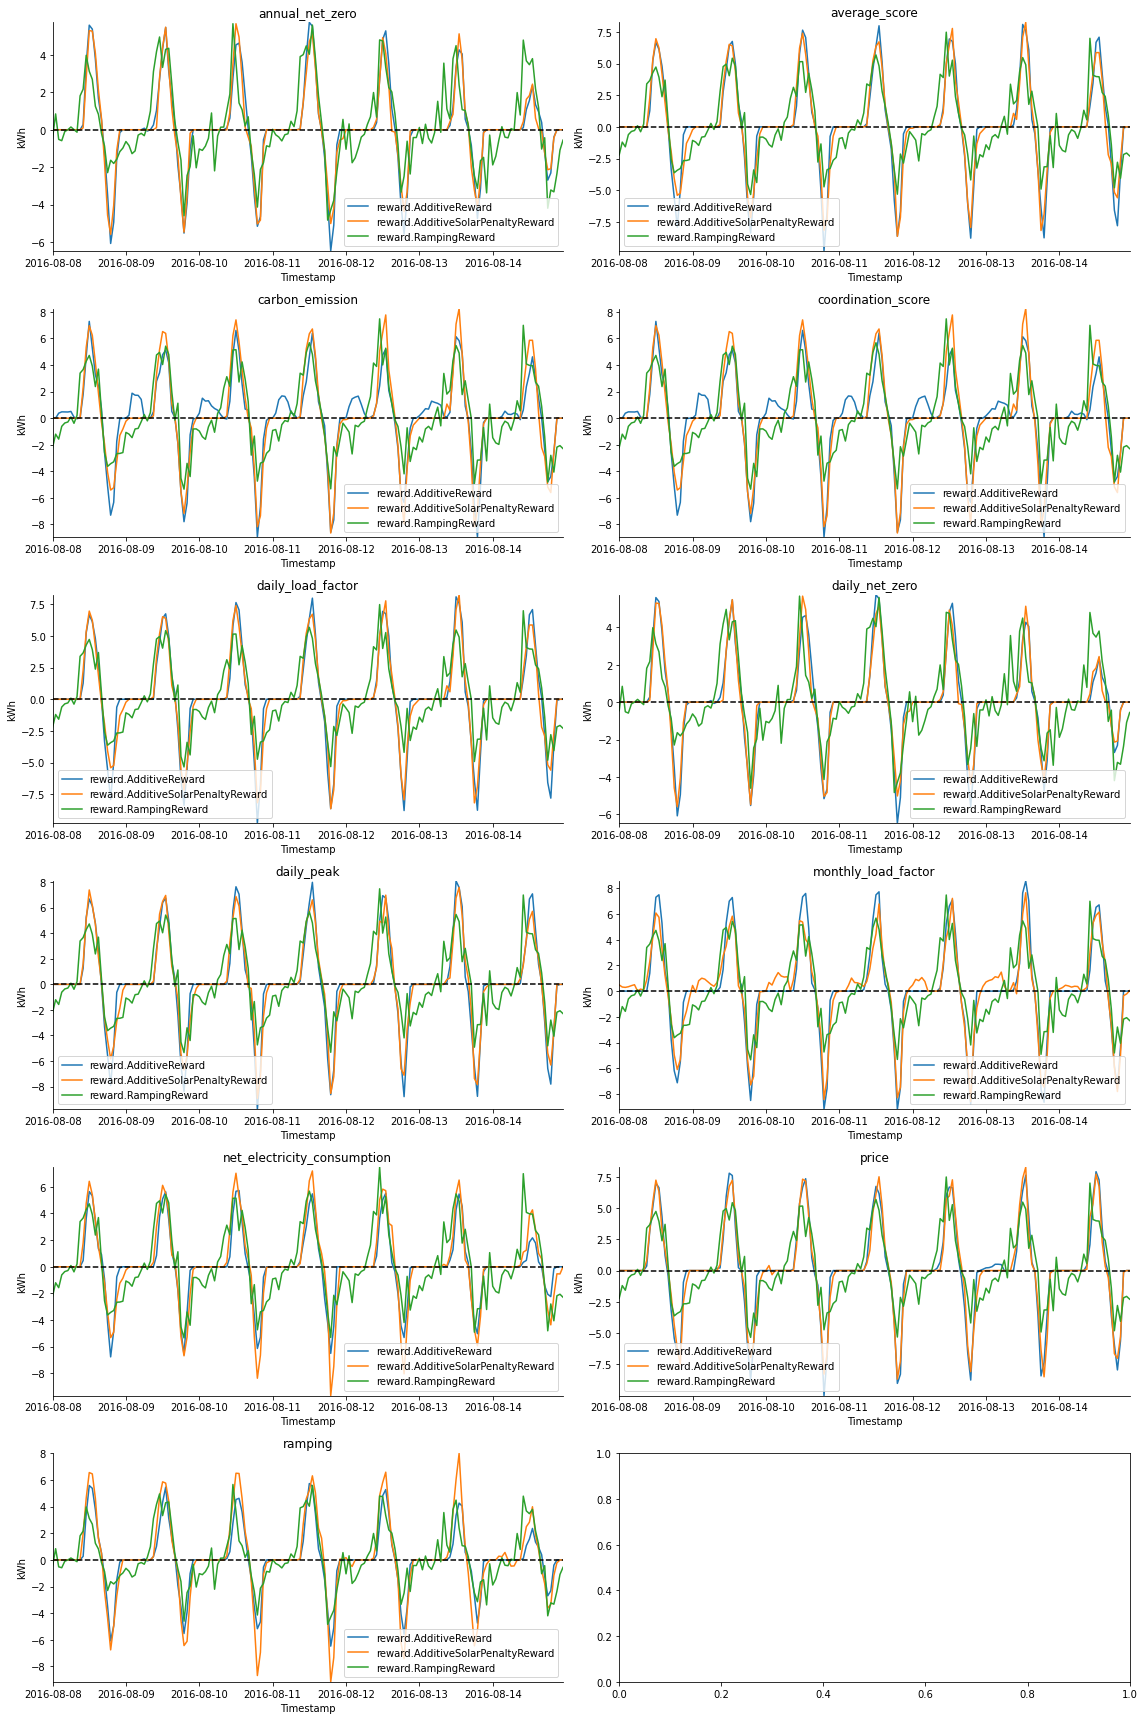

In [156]:
# district specific week profile
group_reward = GRID.groupby(['simulation_group','type']).size().reset_index()
plot_data = district_data.merge(group_reward,on='simulation_group',how='inner')
plot_data = plot_data[~plot_data['type'].isin(['reward.PeakToAverageReward','reward.MultiplicativeReward'])].copy()
plot_data = plot_data[plot_data['episode']==plot_data['episode'].max()].copy()
scores = district_data.columns[2:].tolist()
plot_data = plot_data.melt(id_vars=['type','simulation_group','episode'],value_vars=scores)
plot_data = plot_data.loc[plot_data.groupby(['type','variable'])['value'].idxmin()]
column_count_limit = 2
variables = plot_data['variable'].unique()
row_count = math.ceil(len(variables)/column_count_limit)
column_count = min(column_count_limit, len(variables))
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4))
start_timestamp, end_timestamp = '2016-08-08 00:00:00', '2016-08-14 23:00:00:00'

for ax, ((v, e), v_data) in zip(fig.axes,plot_data.groupby(['variable', 'episode'])):
    simulation_groups = tuple(v_data['simulation_group'].tolist())
    query = f"""
    SELECT
        t.timestamp,
        g.type,
        AVG(t.net_electricity_consumption) AS net_electricity_consumption,
        AVG(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage
    FROM (
        SELECT
            t.timestamp,
            t.simulation_id,
            SUM(t.electrical_storage_electricity_consumption) AS net_electricity_consumption,
            SUM(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage
        FROM detailed_summary t
        WHERE
            t.simulation_id IN (SELECT simulation_id FROM grid WHERE simulation_group IN {simulation_groups})
            AND t.episode = {e}
            AND t.timestamp BETWEEN '{start_timestamp}' AND '{end_timestamp}'
        GROUP BY
            t.simulation_id,
            t.timestamp
    ) t
    LEFT JOIN grid g ON g.simulation_id = t.simulation_id
    GROUP BY
        g.simulation_group,
        t.timestamp
    ORDER BY
        t.timestamp
    """
    v_data = db.query_table(query)
    v_data['timestamp'] = pd.to_datetime(v_data['timestamp'])

    for t, t_data in v_data.groupby(['type']):
        x, y = t_data['timestamp'], t_data['net_electricity_consumption']
        ax.plot(x,y,label=t)

    ax.axhline(0.0,color='black',linestyle='--')
    ax.set_title(v)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('kWh')
    ax.legend()

plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(FIGURES_DIRECTORY,f'reward_design_district_last_episode_average_week_profile.pdf'),bbox_inches='tight',transparent=True)
# plt.close()

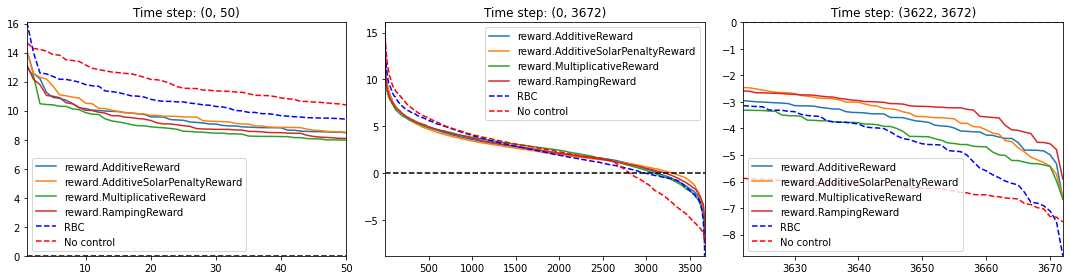

In [102]:
group_reward = GRID.groupby(['simulation_group','type']).size().reset_index()
plot_data = district_data.merge(group_reward,on='simulation_group',how='inner')
plot_data = plot_data[plot_data['episode']==plot_data['episode'].max()].copy()
scores = district_data.columns[2:].tolist()
plot_data = plot_data.melt(id_vars=['type','simulation_group','episode'],value_vars=scores)
plot_data = plot_data.loc[plot_data.groupby(['type','variable'])['value'].idxmin()]
plot_data = plot_data[plot_data['type']!='reward.PeakToAverageReward'].copy()
plot_data = plot_data[plot_data['variable']=='average_score'].copy()
time_steps = [(0,50),(0,3672),(3672-50,3672)]
row_count = 1
column_count = len(time_steps)
fig, _ = plt.subplots(row_count,column_count,figsize=(column_count*5,row_count*4))

for ax, m in zip(fig.axes,time_steps):
    for (t, g, e), _ in plot_data.groupby(['type','simulation_group','episode']):
        query = f"""
        WITH d AS (
            SELECT
                t.episode,
                AVG(t.net_electricity_consumption) AS net_electricity_consumption,
                AVG(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage
            FROM (
                SELECT
                    t.episode,
                    t.simulation_id,
                    t.timestamp,
                    SUM(t.net_electricity_consumption) AS net_electricity_consumption,
                    SUM(t.net_electricity_consumption_without_storage) AS net_electricity_consumption_without_storage
                FROM detailed_summary t
                WHERE
                    t.simulation_id IN (SELECT simulation_id FROM grid WHERE simulation_group = {g})
                GROUP BY
                    t.simulation_id,
                    t.episode,
                    t.timestamp
            ) t
            GROUP BY
                t.episode,
                t.timestamp
        ), f AS (
            SELECT
                ROW_NUMBER() OVER(ORDER BY d.net_electricity_consumption DESC) AS time_step,
                d.net_electricity_consumption AS rbc_value
            FROM d
            WHERE episode = (SELECT MIN(episode) FROM d)
            ORDER BY
                rbc_value DESC
        ), l AS (
            SELECT
                d.net_electricity_consumption AS with_storage_value,
                d.net_electricity_consumption_without_storage AS without_storage_value
            FROM d
            WHERE episode = {e}
        )

        SELECT
            f.time_step,
            f.rbc_value,
            w.with_storage_value,
            o.without_storage_value
        FROM f
        LEFT JOIN (
            SELECT
                ROW_NUMBER() OVER(ORDER BY l.with_storage_value DESC) AS time_step,
                l.with_storage_value
            FROM l
            ORDER BY
                l.with_storage_value DESC
        ) w ON w.time_step = f.time_step
        LEFT JOIN (
            SELECT
                ROW_NUMBER() OVER(ORDER BY l.without_storage_value DESC) AS time_step,
                l.without_storage_value
            FROM l
            ORDER BY
                l.without_storage_value DESC
        ) o ON o.time_step = f.time_step
        WHERE f.time_step BETWEEN {m[0]} AND {m[1]}
        """
        t_data = db.query_table(query)
        x, y = t_data['time_step'], t_data['with_storage_value']
        ax.plot(x,y,label=t)

    # rbc
    y = t_data['rbc_value']
    ax.plot(x,y,label='RBC',linestyle='--',color='blue')
    # no control
    y = t_data['without_storage_value']
    ax.plot(x,y,label='No control',linestyle='--',color='red')

    ax.legend()
    ax.axhline(0.0,color='black',linestyle='--')
    ax.set_title(f'Time step: {m}')

plt.tight_layout()
plt.show()

- control,helps better use of solar, also RBC can end up with higher peak load than no control it seems, which is interesting and important
- the LDC behavior is relatively robust against the choice of the reward function